<a href="https://colab.research.google.com/github/Arnold-Caleb/COVID-19/blob/master/dirty_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount google drive to the colab VM
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#...
FOLDER_NAME = 'COVID-19'

assert FOLDER_NAME is not None, '[!] Enter the folder name'
# Python interpreter of the colab should now load
# .py files from within it
import sys 
sys.path.append('/content/drive/My drive/{}'.format(FOLDER_NAME))

%cd drive/My\ Drive/$FOLDER_NAME

Mounted at /content/drive
/content/drive/My Drive/COVID-19


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [5]:
from utilities import IMG_HEIGHT, IMG_WIDTH, EPOCHS, BATCH_SIZE, TRAIN_DIR, TEST_DIR, VAL_DIR
from utilities.plots import plotImages, learningCurve
from utilities.preprocess import preprocessImages
from utilities.imageloader import loadSingleImage, loadImages

import numpy as np

In [6]:
train_data_gen, val_data_gen, test_data_gen = preprocessImages(TRAIN_DIR,
                                                               VAL_DIR,
                                                               TEST_DIR,
                                                               BATCH_SIZE)

Found 475 images belonging to 3 classes.
Found 163 images belonging to 3 classes.
Found 163 images belonging to 3 classes.


In [7]:
# Set up callbacks for the model's performance
checkpoint = ModelCheckpoint('dirty_covid_model.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True,
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1, 
                              patience=4, 
                              verbose=1,
                              min_delta=0.0001)

callbacks = [checkpoint, reduce_lr] # not including early stopping for now

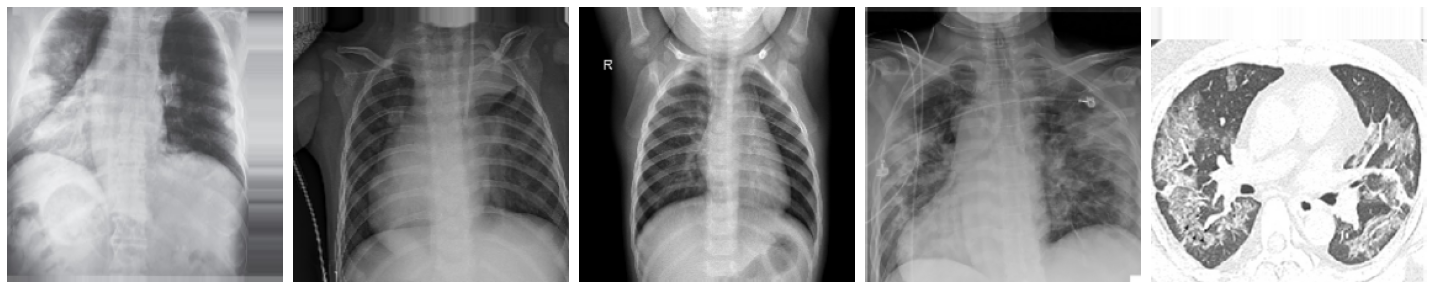

In [8]:
training_images, training_labels = next(train_data_gen) 

plotImages(training_images[:5])

In [9]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D())

    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))

    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))

    model.add(Dropout(0.2))
    model.add(Dense(3))
    
    return model

model = create_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
history = model.fit(train_data_gen, 
                    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=val_data_gen,
                    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE)))
                    )

Epoch 1/25
15/15 [==============================] - ETA: 0s - loss: 1.4640 - accuracy: 0.3642
Epoch 00001: val_loss improved from inf to 1.07086, saving model to dirty_covid_model.h5
15/15 [==============================] - 35s 2s/step - loss: 1.4640 - accuracy: 0.3642 - val_loss: 1.0709 - val_accuracy: 0.4724 - lr: 0.0010
Epoch 2/25
15/15 [==============================] - ETA: 0s - loss: 0.9524 - accuracy: 0.5600
Epoch 00002: val_loss improved from 1.07086 to 0.67420, saving model to dirty_covid_model.h5
15/15 [==============================] - 35s 2s/step - loss: 0.9524 - accuracy: 0.5600 - val_loss: 0.6742 - val_accuracy: 0.6196 - lr: 0.0010
Epoch 3/25
15/15 [==============================] - ETA: 0s - loss: 0.6375 - accuracy: 0.7242
Epoch 00003: val_loss improved from 0.67420 to 0.37816, saving model to dirty_covid_model.h5
15/15 [==============================] - 35s 2s/step - loss: 0.6375 - accuracy: 0.7242 - val_loss: 0.3782 - val_accuracy: 0.8344 - lr: 0.0010
Epoch 4/25
15/15 

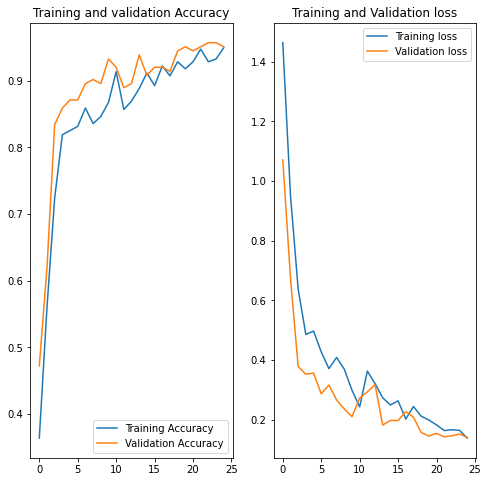

6/6 [==============================] - 3s 554ms/step - loss: 0.2073 - accuracy: 0.9325


In [11]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']

epochs_range = range(EPOCHS)

learningCurve(epochs_range=epochs_range, 
              acc=acc, 
              val_acc=val_acc, 
              loss=loss, 
              val_loss=val_loss)

test_loss, test_acc = model.evaluate(test_data_gen)


In [12]:
# After building the model, time to test it on new data.
classifier = load_model('dirty_covid_model.h5')

_, accuracy = classifier.evaluate(test_data_gen, verbose=1)

accuracy

6/6 [==============================] - 4s 600ms/step - loss: 0.2073 - accuracy: 0.9325


0.9325153231620789

In [13]:
predictions = ['COVID-19', 'Normal', 'Pneumonia']
predictions = np.array(predictions)

case1 = loadImages('./datasets/test/corona')
case2 = loadImages('./datasets/test/normal')
case3 = loadImages('./datasets/test/pneumonia')

cases = [case1, case2, case3]
j = 0
for case in cases:
  pred = classifier.predict_classes(case)

  results = [predictions[i] for i in pred]
  corr = [i for i in results if i == predictions[j]]
  print('Got {} out of {} of the {} cases correct!'.format(len(corr), len(pred), predictions[j]))
  j = j+1


# The accuracy obtained for the test data is quite unrealistic...

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Got 39 out of 44 of the COVID-19 cases correct!
Got 51 out of 57 of the Normal cases correct!
Got 62 out of 62 of the Pneumonia cases correct!
